In [129]:
import os 
from glob import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [114]:
def get_average_non_vntr_coverage(fn):
    """
    Determine the average depth for results using samtools bedcov.
    """
    
    coverage = pd.read_table(fn, header=None)
    coverage.columns = ['Chrom', 'Start', 'Stop', 'Base_Overlaps']
    coverage['Coverage'] = [float(sr['Base_Overlaps']) / (sr['Stop'] - sr['Start']) if sr['Base_Overlaps'] > 0 \
                            else 0 for index, sr in coverage.iterrows()]    
    return coverage['Coverage'].mean()

In [115]:
def get_average_vntr_coverage(fn, copy_len=65):
    """
    Determine the average depth for results using samtools bedcov.
    """
    
    coverage = pd.read_table(fn, header=None)
    coverage.columns = ['Chrom', 'Start', 'Stop', 'Base_Overlaps']
    return coverage['Base_Overlaps'].sum() / copy_len

In [116]:
vntr_fns = glob('../output/pipeline/sample/*/coverage_*/*.vntr.cov')
vntr_fns.sort()
non_vntr_fns = glob('../output/pipeline/sample/*/coverage_*/*.non_vntr.cov')
non_vntr_fns.sort()

coverage = []
for vntr_fn, non_vntr_fn in zip(vntr_fns, non_vntr_fns):
    
    sample = os.path.basename(vntr_fn).split('.')[0]
    
    
    vntr_coverage = get_average_vntr_coverage(vntr_fn)
    non_vntr_coverage = get_average_non_vntr_coverage(non_vntr_fn)
    copy_number = vntr_coverage / non_vntr_coverage
    
    
    
    
    coverage.append([sample, vntr_coverage, non_vntr_coverage, copy_number])
    
coverage = pd.DataFrame(coverage, columns=['Sample_Name', 'VNTR_Coverage', 'Non_VNTR_Coverage', 'Copy_Number'])

In [117]:
coverage

,Sample_Name,VNTR_Coverage,Non_VNTR_Coverage,Copy_Number
0,sequence_10000_case_1,208,29.698400,7.003744
1,sequence_10000_case_2,198,29.714525,6.663408
2,sequence_10000_case_3,200,29.711775,6.731338
3,sequence_10000_case_4,183,29.739200,6.153494


In [118]:
coverage = pd.read_table(vntr_fn, header=None)
coverage.columns = ['Chrom', 'Start', 'Stop', 'Base_Overlaps']

In [119]:
coverage

,Chrom,Start,Stop,Base_Overlaps
0,seq0,5000,5000,0
1,seq1,5000,5065,2073
2,seq2,5000,5130,3556
3,seq3,5000,5195,6303


In [186]:
def calc_coverage_samtools_depth(fn, copy_len=65):
    data = pd.read_table(fn, header=None)
    data.columns = ['chrom', 'pos', 'depth']
    data['copy_number'] = [int(x) for x in data['chrom'].str.extract('([0-9]*$)')]
    gdata = data.groupby('chrom')
    depth_summary = gdata.apply(np.mean)
    depth_summary['true_depth'] = [sr['depth'] * sr['copy_number'] for index, sr in depth_summary.iterrows()]
    return depth_summary['true_depth'].sum() / depth_summary.shape[0]

In [187]:
fn = './../output/pipeline/sample/sequence_10000_case_4/coverage_100/sequence_10000_case_4.vntr.depth'

In [188]:
data = pd.read_table(fn, header=None)
data.columns = ['chrom', 'pos', 'depth']
data['copy_number'] = [int(x) for x in data['chrom'].str.extract('([0-9]*$)')]
gdata = data.groupby('chrom')
depth_summary = gdata.apply(np.mean)
depth_summary['true_depth'] = [sr['depth'] * sr['copy_number'] for index, sr in depth_summary.iterrows()]

In [189]:
depth_summary

,pos,depth,copy_number,true_depth
chrom,,,,
seq1,5033.0,95.015385,1,95.015385
seq2,5065.5,106.053846,2,212.107692
seq3,5098.0,93.256410,3,279.769231


In [190]:
calc_copy_number_samtools_depth(fn, copy_len=65)

195.63076923076923

In [193]:
fn = './../output/pipeline/sample/sequence_10000_case_4/coverage_100/sequence_10000_case_4.non_vntr.depth'

In [194]:
calc_copy_number_samtools_depth(fn, copy_len=65)

148.72703380142917

In [183]:
fn = './../output/pipeline/sample/sequence_10000_case_1/coverage_100/sequence_10000_case_1.non_vntr.depth'

In [184]:
calc_copy_number_samtools_depth(fn, copy_len=65)

148.84496012868743

In [ ]:
plt.plot()

In [316]:
# Whole simulation data 
data = pd.read_table('../output/pipeline/sample/sequence_10000_case_2/coverage_100/simulation.depth', header=None)
data.columns = ['chrom', 'pos', 'depth']
#data['copy_number'] = [int(x) for x in data['chrom'].str.extract('([0-9]*$)')]
#data['chrom_pos'] = ['{}{}'.format(sr['copy_number'], sr['pos']) for index, sr in data.iterrows()]
gdata = data.groupby('chrom')

In [374]:
def get_intervals(copy_number, len_vntr=65, point=5000):
    intervals = [[-100, -100]]
    for i in range(1, copy_number):
        intervals.append([point, point + len_vntr])
        point = point + len_vntr
    return intervals

def get_vntr_position(position, intervals):
    vntr_position = position 
    for i, interval in enumerate(intervals):
        if (interval[0] < position) and (interval[1] > position):
            vntr_position = position - interval[0]
    return vntr_position

def get_vntr_position(position, interval):
    vntr_position = position 
    if (interval[0] < position) and (interval[1] > position):
        vntr_position = position - interval[0]
    return vntr_position

In [ ]:
# CONVERTING the template position into a vntr specific position
num_templates = data['chrom'].unique().shape[0]
intervals = get_intervals(num_templates, len_vntr=65, point=5000)
vntr_positions = [] 
for grp, chrom_df in data.groupby('chrom'):
    copy_number = int(grp.replace('seq', ''))
    interval = intervals[copy_number]
    for index, sr in chrom_df.iterrows():
        vntr_position = get_vntr_position(sr['pos'], interval)
        vntr_positions.append(vntr_position)
data['vntr_based_pos'] = vntr_positions
data = data[['chrom', 'pos','vntr_based_pos', 'depth']]

In [393]:
vpos = data.groupby('vntr_based_pos')

In [394]:
vpos.count()

,chrom,pos,depth
vntr_based_pos,,,
1,4,4,4
2,6,6,6
3,6,6,6
4,7,7,7
5,7,7,7
6,7,7,7
7,7,7,7
8,7,7,7
9,7,7,7


In [391]:
vpos = vpos['depth'].sum().to_frame()

KeyError: 'depth'

In [392]:
vpos.cou

10192

In [384]:
vpos = vpos['depth'].mean().to_frame()

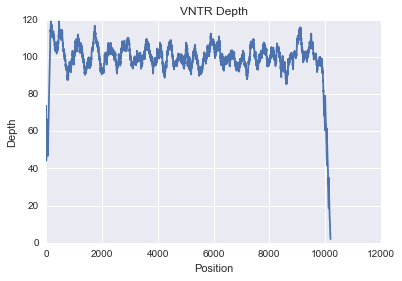

In [385]:
fig, ax = plt.subplots()

plt.plot(vpos.index, vpos['depth'],)
ax.set_title('VNTR Depth')
ax.set_xlabel('Position')
ax.set_ylabel('Depth')
#ax.set_ylim(bottom=0, top=15)

In [387]:
vpos.depth.describe()

count    10192.000000
mean        98.751913
std         11.447098
min          2.000000
25%         96.250000
50%         99.750000
75%        104.250000
max        119.000000
Name: depth, dtype: float64

In [263]:
gdata.groups.keys()

['seq3', 'seq2', 'seq1', 'seq0']

(0, 30)

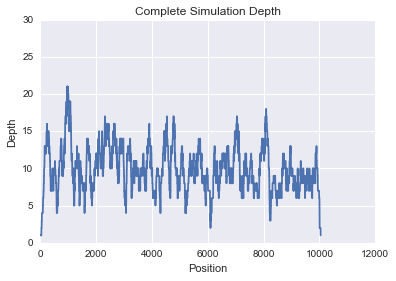

In [257]:
template = gdata.get_group('seq1')
fig, ax = plt.subplots()

plt.plot(template['pos'], template['depth'],)
ax.set_title('Complete Simulation Depth')
ax.set_xlabel('Position')
ax.set_ylabel('Depth')
ax.set_ylim(bottom=0, top=30)

(0, 30)

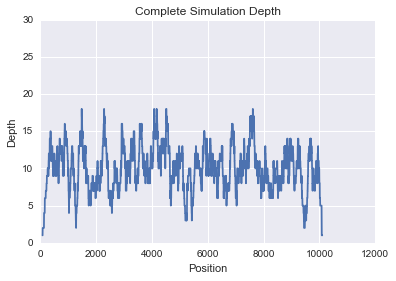

In [258]:
template = gdata.get_group('seq2')
fig, ax = plt.subplots()

plt.plot(template['pos'], template['depth'],)
ax.set_title('Complete Simulation Depth')
ax.set_xlabel('Position')
ax.set_ylabel('Depth')
ax.set_ylim(bottom=0, top=30)

(0, 30)

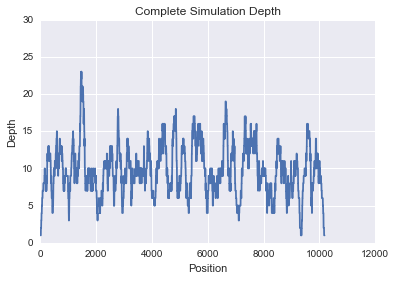

In [259]:
template = gdata.get_group('seq3')
fig, ax = plt.subplots()

plt.plot(template['pos'], template['depth'],)
ax.set_title('Complete Simulation Depth')
ax.set_xlabel('Position')
ax.set_ylabel('Depth')
ax.set_ylim(bottom=0, top=30)

### Non-VNTR

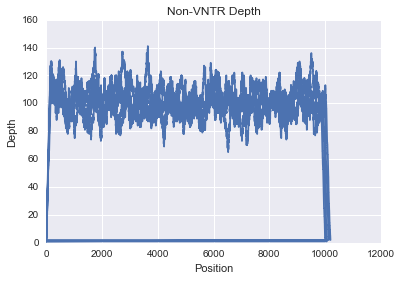

In [423]:
data = pd.read_table('../output/pipeline/sample/sequence_10000_case_2/coverage_100/sequence_10000_case_2.non_vntr.depth', header=None)
data.columns = ['chrom', 'pos', 'depth']
fig, ax = plt.subplots()


plt.plot(data['pos'], data['depth'],)
ax.set_title('Non-VNTR Depth')
ax.set_xlabel('Position')
ax.set_ylabel('Depth')
#ax.set_ylim(bottom=0, top=30)


In [424]:
data.depth.sum()/data.shape[0]

99

### VNTR

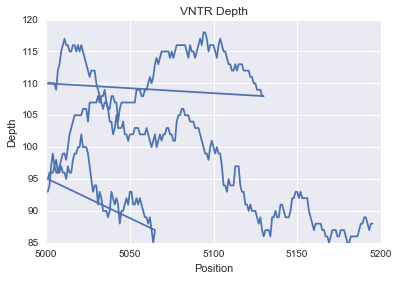

In [413]:
data = pd.read_table('../output/pipeline/sample/sequence_10000_case_2/coverage_100/sequence_10000_case_2.vntr.depth', header=None)
data.columns = ['chrom', 'pos', 'depth']
#data = data[data['chrom'] == 'seq1']

fig, ax = plt.subplots()

plt.plot(data['pos'], data['depth'],)
ax.set_title('VNTR Depth')
ax.set_xlabel('Position')
ax.set_ylabel('Depth')
#ax.set_ylim(bottom=0, top=15)

In [416]:
data.chrom.unique()

array(['seq1', 'seq2', 'seq3'], dtype=object)

In [419]:
data.groupby('chrom')

In [420]:
data.head()

,chrom,pos,depth
0,seq1,5001,93
1,seq1,5002,94
2,seq1,5003,97
3,seq1,5004,99
4,seq1,5005,97


In [422]:
data.depth.sum()/65

606